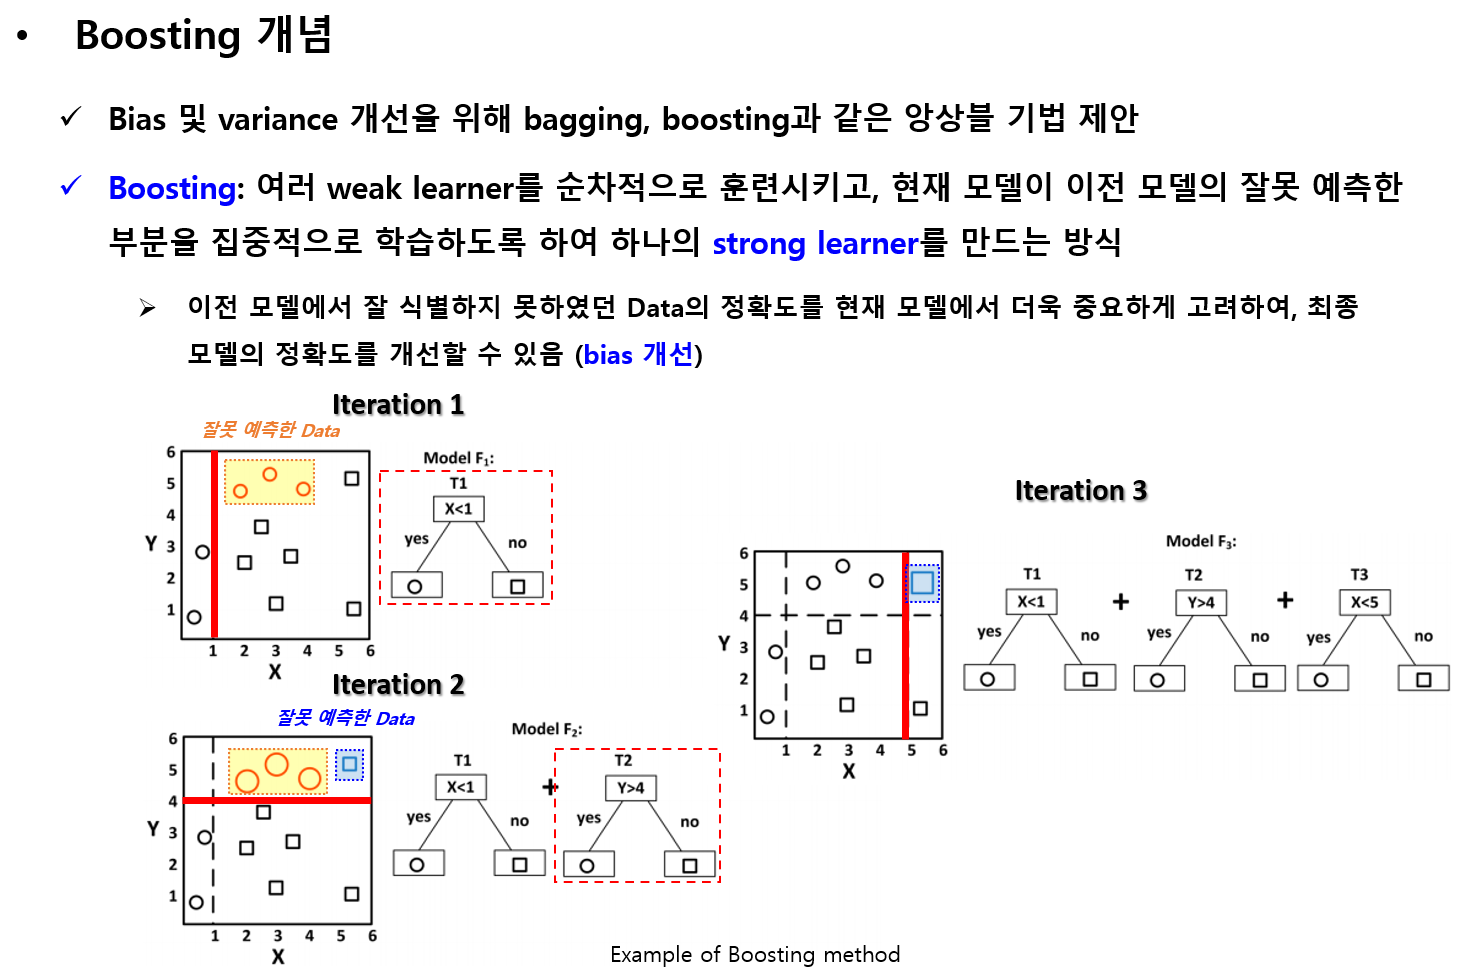

## **GBM (Regression): 발전소 전기 에너지 출력(PE) 예측**

In [1]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/Yong-Gon/LG2025_Boosting.git #코랩 사용

Cloning into 'LG2025_Boosting'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 7.58 MiB | 6.72 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
'''
CCPP Data : 6년 간(2006-2011) 발전소가 최대 부하로 작동할 때 시간당 순수 전기 에너지 출력(PE)를
평균 주변 온도(AT), 주변 압력(AP), 상대 습도(RH), 배기 진공(V) 센서 데이터를 이용해 예측하는 데이터
'''

# 데이터 불러오기
dt = pd.read_csv("/content/LG2025_Boosting/CCPP.csv", encoding = "UTF-8-sig")
dt.head(10)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


In [4]:
# 데이터 타입(type) 확인
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [5]:
'''
결측치가 존재할 경우, 특정 값(0)으로 replace 가능
df.replace(np.nan,'0',inplace = True)
'''

# 데이터 결측치 확인
dt.isna().sum()

,0
AT,0
V,0
AP,0
RH,0
PE,0


In [6]:
# 데이터 분포(통계량) 확인
dt.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


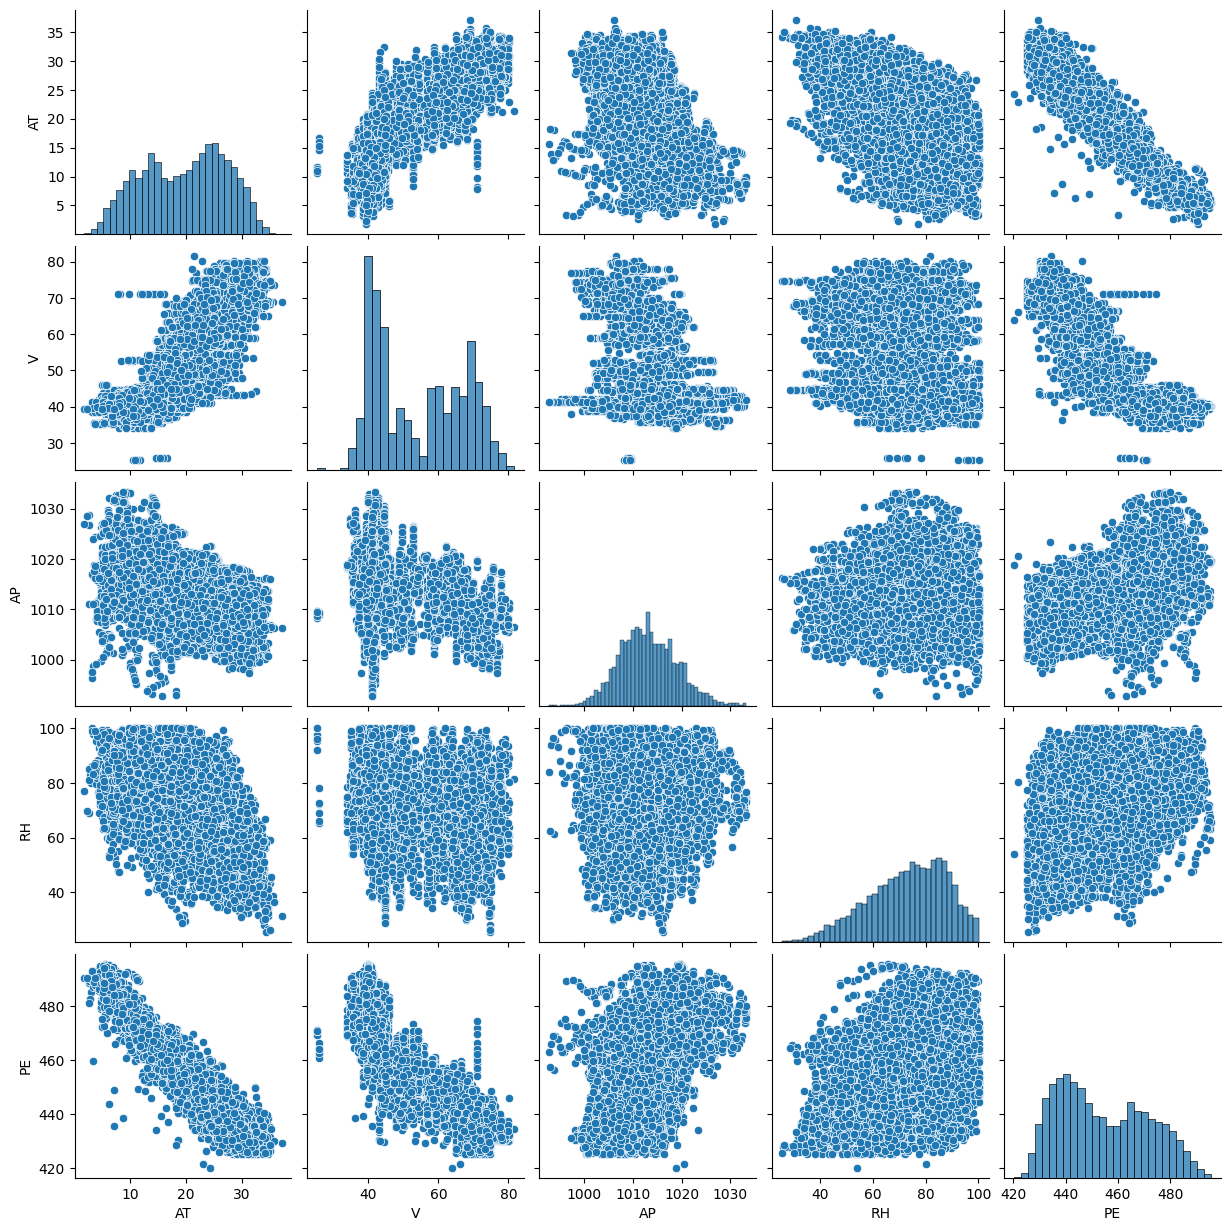

In [7]:
# 데이터 분포(그래프) 확인
sns.pairplot(dt)

In [8]:
# 변수 별 상관계수
dt.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


In [9]:
# 학습 데이터와 테스트 데이터 구분

# 학습 데이터 비율: 0.7, 테스트 데이터 비율: 0.3
train_data, test_data = train_test_split(dt, train_size = 0.7)

# 독립변수(Xs)와 종속변수(Y) 구분
train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y(종속변수) 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y(종속변수) 따로 저장

In [10]:
test_X.head()

,AT,V,AP,RH
0,30.66,70.98,1007.60,72.08
1,14.08,40.10,1015.48,82.81
2,13.18,40.24,1016.81,86.71
3,17.84,52.08,1006.65,100.09
4,20.08,49.69,1008.34,69.88


In [11]:
# GBM 모델(예측) package 불러오기
from sklearn.ensemble import GradientBoostingRegressor

#모델 파라미터 설정
'''
파라미터 목록: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
'''
model = GradientBoostingRegressor(loss          = "squared_error",
                                  learning_rate = 0.1,
                                  n_estimators  = 100,
                                  criterion     = "squared_error", # mse = squared_error
                                  max_depth     = 3,
                                  min_samples_split = 2,
                                  min_samples_leaf  = 1,
                                  verbose = 1)

#설정된 모델 파라미터에 데이터 fitting (GBM 학습)
model.fit(train_X, train_Y)

      Iter       Train Loss   Remaining Time 
         1         238.6334            6.14s
         2         198.1372            4.72s
         3         165.1721            3.97s
         4         138.3035            3.75s
         5         116.4267            3.27s
         6          98.5342            2.96s
         7          83.9602            3.14s
         8          71.9994            3.22s
         9          62.2837            3.16s
        10          54.3065            3.32s
        20          22.2358            3.04s
        30          16.8507            2.53s
        40          15.4764            2.16s
        50          14.8555            1.82s
        60          14.4975            1.35s
        70          14.1699            0.96s
        80          13.8922            0.62s
        90          13.6520            0.29s
       100          13.3851            0.00s


GradientBoostingRegressor(criterion='squared_error', verbose=1)

In [12]:
# 학습한 GBM 모델을 통해 테스트 데이터 예측

# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

# 예측 결과 확인 (첫 10 instances)
pred.head(10)

,PE,pred
0,435.66,432.323904
1,469.33,468.658902
2,469.35,471.055273
3,450.67,452.369290
4,453.54,451.833596
5,475.02,478.010154
6,453.02,453.270730
7,475.61,471.642484
8,482.99,480.766374
9,444.00,454.411188


- 예측 모델 평가지표

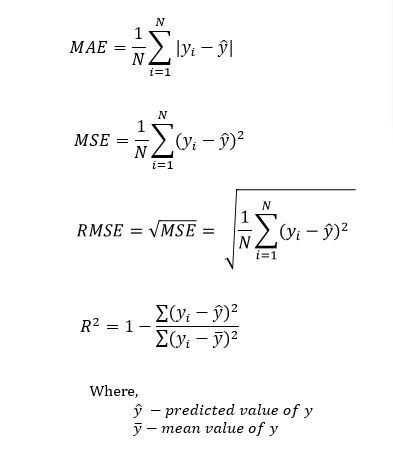

In [13]:
# 예측 값과 실제 값 간의 오차 확인

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(pred.PE, pred.pred)
print("MAE : ", MAE)

# Mean Squared Error (MSE)
MSE = mean_squared_error(pred.PE, pred.pred)
print("MSE : ", MSE)

# Rooted Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(pred.PE, pred.pred))
print("RMSE : ", RMSE)

# 예측 값과 실제 값 간의 R^2(결정 계수) 계산
# 분산 기반으로 예측 성능을 평가 / 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
r2 = r2_score(pred.PE, pred.pred)
print("R-squared : ", r2)

MAE :  2.9442654662712955
MSE :  15.142461014820917
RMSE :  3.891331522091239
R-squared :  0.9491311377067736


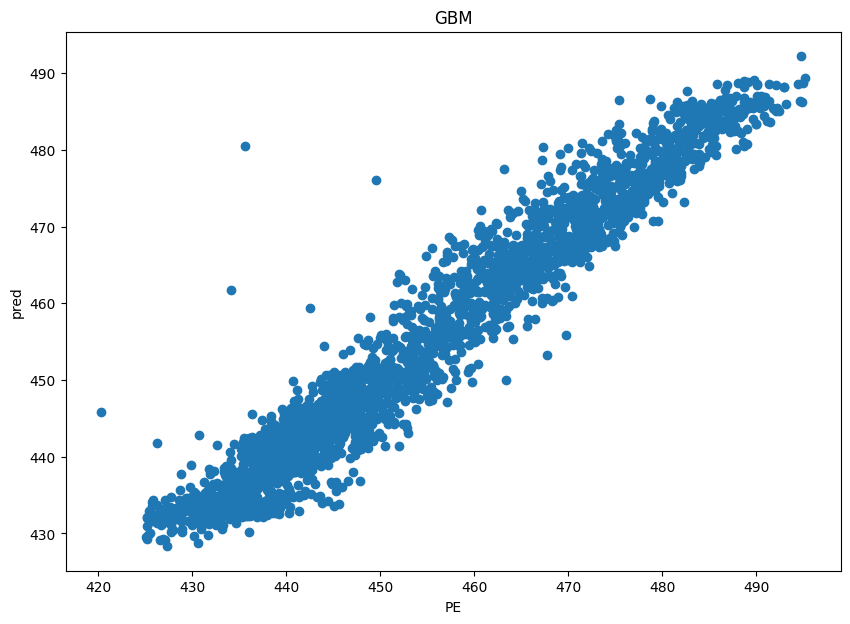

In [14]:
# 오차 Plot
plt.figure(figsize = (10, 7))
plt.title("GBM")
plt.scatter(pred.PE, pred.pred)
plt.xlabel("PE")
plt.ylabel("pred")
plt.show()

In [15]:
# 500번의 반복(iteration)에 대해 예측 결과 할당

# 빈 공간의 ndarray 생성
test_score = np.zeros((100,), dtype=np.float64)

# 예측 값 (y_pred)와 실제 값 (y_test)의 loss를 test_score에 저장
# 학습이 진행될수록 loss값이 0에 가깝게 줄어드는 것을 확인할 수 있음
for i, y_pred in enumerate(model.staged_predict(test_X)):
    test_score[i] = mean_squared_error(test_Y, y_pred)

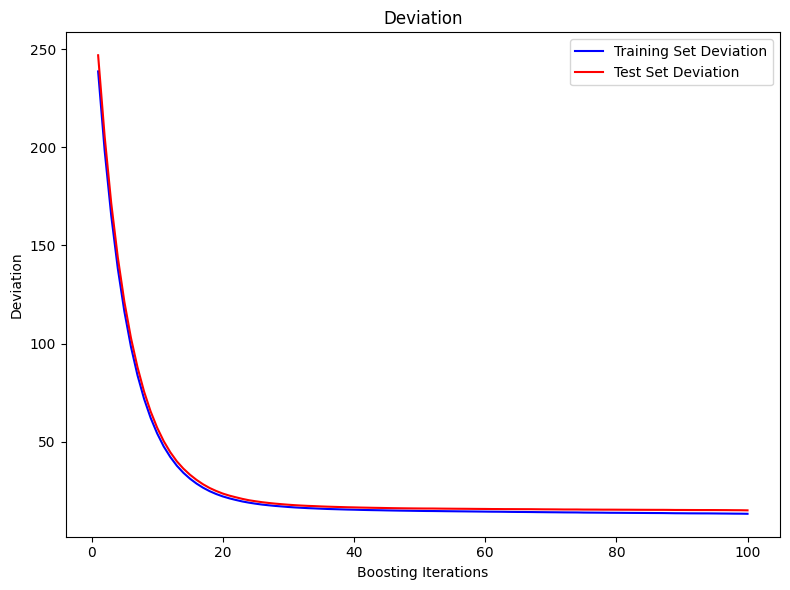

In [16]:
# 500 iteration에 대한 학습 데이터 loss 값(파란선)과 테스트 데이터 loss 값(빨간선)을 확인할 수 있음
# 반복이 거듭될수록 loss값이 감소하며, 점차 0에 가까운 값으로 수렴함

fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
plt.title('Deviation')
plt.plot(np.arange(100) + 1, model.train_score_, 'b-', label='Training Set Deviation')
plt.plot(np.arange(100) + 1, test_score, 'r-', label='Test Set Deviation')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviation')
fig.tight_layout()
plt.show()

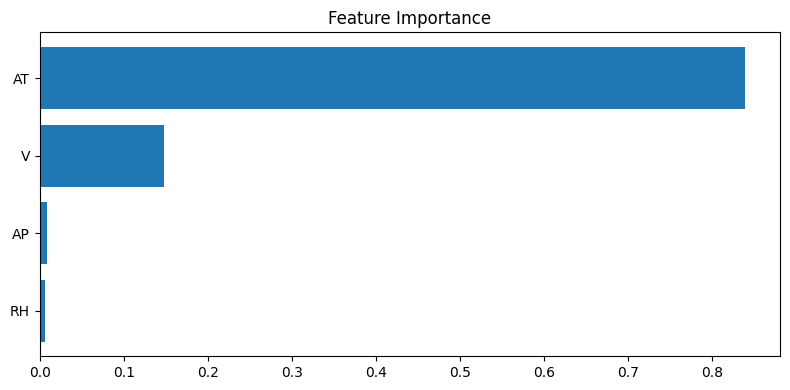

In [17]:
# 의사결정나무 앙상블을 기반으로 하여, GBM 모델을 통해 변수 중요도 추출 가능

# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = model.feature_importances_

# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)

# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dt.columns)[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
plt.show()

## **GBM (Classification): 가입자 이탈 여부 예측**

In [18]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score  ## 면적 아래 계산 1에 가까울 수록 좋음

from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [19]:
!git clone https://github.com/Yong-Gon/LG2025_Boosting.git #코랩 사용

fatal: destination path 'LG2025_Boosting' already exists and is not an empty directory.


In [20]:
'''
가입자 이탈/이탈률 dataset : 전체 19개 피처와 1개의 타겟으로 구성 (Categorical feature: State, Area_code, Int.l.Plan, VMail.Plan)
타겟명: 'Churn.' / True(1)는 이탈한 고객, False(0)는 이탈하지 않은 고객을 의미함
'''

# 데이터 불러오기
dt2 = pd.read_csv("/content/LG2025_Boosting/churn.csv")
print('dataset shape:', dt2.shape)

# 데이터 확인
dt2.head()

dataset shape: (3333, 20)


,State,Account.Length,Area.Code,Int.l.Plan,VMail.Plan,VMail.Message,Day.Mins,Day.Calls,Day.Charge,Eve.Mins,Eve.Calls,Eve.Charge,Night.Mins,Night.Calls,Night.Charge,Intl.Mins,Intl.Calls,Intl.Charge,CustServ.Calls,Churn.
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [21]:
# 데이터 타입(type) 확인
dt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account.Length  3333 non-null   int64  
 2   Area.Code       3333 non-null   int64  
 3   Int.l.Plan      3333 non-null   object 
 4   VMail.Plan      3333 non-null   object 
 5   VMail.Message   3333 non-null   int64  
 6   Day.Mins        3333 non-null   float64
 7   Day.Calls       3333 non-null   int64  
 8   Day.Charge      3333 non-null   float64
 9   Eve.Mins        3333 non-null   float64
 10  Eve.Calls       3333 non-null   int64  
 11  Eve.Charge      3333 non-null   float64
 12  Night.Mins      3333 non-null   float64
 13  Night.Calls     3333 non-null   int64  
 14  Night.Charge    3333 non-null   float64
 15  Intl.Mins       3333 non-null   float64
 16  Intl.Calls      3333 non-null   int64  
 17  Intl.Charge     3333 non-null   f

In [22]:
# 데이터 전처리

# column name 중 "."을 "_"으로 변경
dt2.columns = dt2.columns.str.replace(".","_")

# data중 Area.Code는 지역숫자로 수치적 의미를 갖지 않으므로, category 형태로 변경
'''
- category: 가능한 값의 범위가 고정적 or 한정적일 때 사용 (ex. 아침식사 여부: 0, 1)
- object: 문자열이거나 범위가 한정적이지 않을 경우 사용   (ex. 아침식사 종류: 샐러드, 소고기, 바나나, 샌드위치 등)
'''
dt2.Area_Code = dt2.Area_Code.astype("category")

print(dt2['Churn_'].value_counts())

unsatisfied_cnt = dt2[dt2['Churn_'] == "True." ].Churn_.count()
total_cnt = dt2.Churn_.count()

print('\n이탈자 비율은 {0:.3f}'.format((unsatisfied_cnt / total_cnt))) # True: 이탈

Churn_
False.    2850
True.      483
Name: count, dtype: int64

이탈자 비율은 0.145


In [23]:
# 변경된 데이터 타입(type) 확인
dt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   State           3333 non-null   object  
 1   Account_Length  3333 non-null   int64   
 2   Area_Code       3333 non-null   category
 3   Int_l_Plan      3333 non-null   object  
 4   VMail_Plan      3333 non-null   object  
 5   VMail_Message   3333 non-null   int64   
 6   Day_Mins        3333 non-null   float64 
 7   Day_Calls       3333 non-null   int64   
 8   Day_Charge      3333 non-null   float64 
 9   Eve_Mins        3333 non-null   float64 
 10  Eve_Calls       3333 non-null   int64   
 11  Eve_Charge      3333 non-null   float64 
 12  Night_Mins      3333 non-null   float64 
 13  Night_Calls     3333 non-null   int64   
 14  Night_Charge    3333 non-null   float64 
 15  Intl_Mins       3333 non-null   float64 
 16  Intl_Calls      3333 non-null   int64   
 17  Intl_Charge   

In [24]:
# 독립변수(Xs)와 종속변수(Y) 구분
X_features = dt2.iloc[:, :-1]
y_labels = dt2.iloc[:, -1]

# 타겟 변수에 대해 불만족한 고객 ('True.')을 1로, 나머지는 0으로 해서 최종적으로 binary class {1, 0}로 변경
y_labels = np.where(y_labels == "True.", 1, 0)
y_labels = pd.Series(y_labels)

print('type of labels:{0}'.format(np.unique(y_labels)))

type of labels:[0 1]


In [25]:
# object 타입을 category로 변경
for col in X_features.columns:
    if X_features[col].dtypes == "O":
        X_features[col] = X_features[col].astype('category')

# 데이터 타입(type) 확인
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   State           3333 non-null   category
 1   Account_Length  3333 non-null   int64   
 2   Area_Code       3333 non-null   category
 3   Int_l_Plan      3333 non-null   category
 4   VMail_Plan      3333 non-null   category
 5   VMail_Message   3333 non-null   int64   
 6   Day_Mins        3333 non-null   float64 
 7   Day_Calls       3333 non-null   int64   
 8   Day_Charge      3333 non-null   float64 
 9   Eve_Mins        3333 non-null   float64 
 10  Eve_Calls       3333 non-null   int64   
 11  Eve_Charge      3333 non-null   float64 
 12  Night_Mins      3333 non-null   float64 
 13  Night_Calls     3333 non-null   int64   
 14  Night_Charge    3333 non-null   float64 
 15  Intl_Mins       3333 non-null   float64 
 16  Intl_Calls      3333 non-null   int64   
 17  Intl_Charge   

In [26]:
# GBM에서 categorical feature에 대해 one-hot encoding 진행
def onehot(data, feature):

    return pd.concat([data, pd.get_dummies(data[feature], prefix=feature)], axis=1).drop([feature], axis=1)

# 다음 4가지 categorical feature에 대해 one-hot encoding을 진행 후 기존 X_feature에 결합
cate_list = ['State', 'Area_Code', 'Int_l_Plan', 'VMail_Plan']

for i in range(len(cate_list)):

    X_features = onehot(X_features, cate_list[i])

In [27]:
# 추가된 feature 확인
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   VMail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Day_Calls       3333 non-null   int64  
 4   Day_Charge      3333 non-null   float64
 5   Eve_Mins        3333 non-null   float64
 6   Eve_Calls       3333 non-null   int64  
 7   Eve_Charge      3333 non-null   float64
 8   Night_Mins      3333 non-null   float64
 9   Night_Calls     3333 non-null   int64  
 10  Night_Charge    3333 non-null   float64
 11  Intl_Mins       3333 non-null   float64
 12  Intl_Calls      3333 non-null   int64  
 13  Intl_Charge     3333 non-null   float64
 14  CustServ_Calls  3333 non-null   int64  
 15  State_AK        3333 non-null   bool   
 16  State_AL        3333 non-null   bool   
 17  State_AR        3333 non-null   b

In [28]:
# 학습 데이터와 테스트 데이터 구분
# 학습 데이터 비율: 0.8, 테스트 데이터 비율: 0.2
train_X, test_X, train_y, test_y = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = train_y.count()
test_cnt = test_y.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(train_X.shape , test_X.shape))

print('\n학습 세트 레이블 값 분포 비율')
print(train_y.value_counts()/train_cnt)

print('\n테스트 세트 레이블 값 분포 비율')
print(test_y.value_counts()/test_cnt)

학습 세트 Shape:(2666, 73), 테스트 세트 Shape:(667, 73)

학습 세트 레이블 값 분포 비율
0    0.851838
1    0.148162
Name: count, dtype: float64

테스트 세트 레이블 값 분포 비율
0    0.868066
1    0.131934
Name: count, dtype: float64


In [29]:
# GBM 모델 package 불러오기
from sklearn.ensemble import GradientBoostingClassifier

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

# 모델 생성 및 train data로 fitting (학습) 진행
clf = GradientBoostingClassifier(loss             = 'log_loss',
                                 criterion        = 'squared_error', # 개별 트리의 불순도 측도
                                 n_estimators     = 100,
                                 min_samples_leaf = 5,
                                 max_depth        = 3,
                                 learning_rate    = 1,
                                 random_state     = 0)
clf.fit(train_X , train_y)

# GBM 실험 종료에 대한 시간 측정
gb_time = time.time() - start_time
print("GBM 수행 시간: {0:.2f} 초 ".format(gb_time))

GBM 수행 시간: 4.36 초 


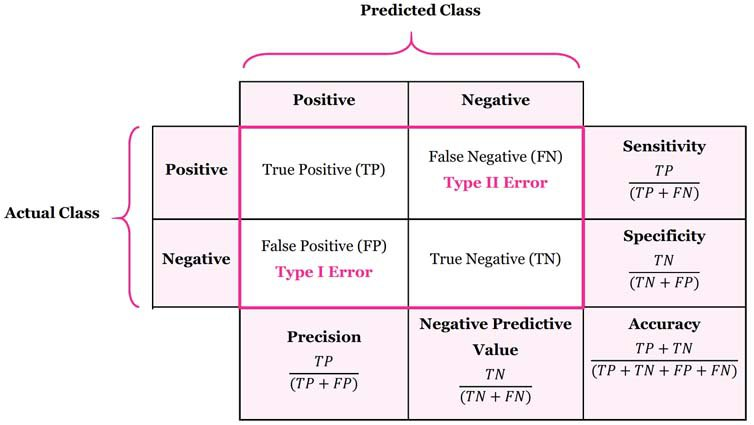

In [30]:
# 학습 완료된 GBM 모델을 통해 테스트 데이터 예측
pred = clf.predict(test_X)

# 예측 값과 실제 값 간의 비교를 통해, 정확도(차이) 계산
accuracy = accuracy_score(test_y, pred)
print('GBM 정확도: {0:.4f}'.format(accuracy))

GBM 정확도: 0.9340


In [31]:
# precision/recall/f1-score/accuracy 산출
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       579
           1       0.76      0.74      0.75        88

    accuracy                           0.93       667
   macro avg       0.86      0.85      0.85       667
weighted avg       0.93      0.93      0.93       667



In [32]:
# 예측 값과 실제 값 간의 비교를 통해, AUC 계산
roc_score = roc_auc_score(test_y, clf.predict_proba(test_X)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(roc_score))

ROC AUC: 0.8744


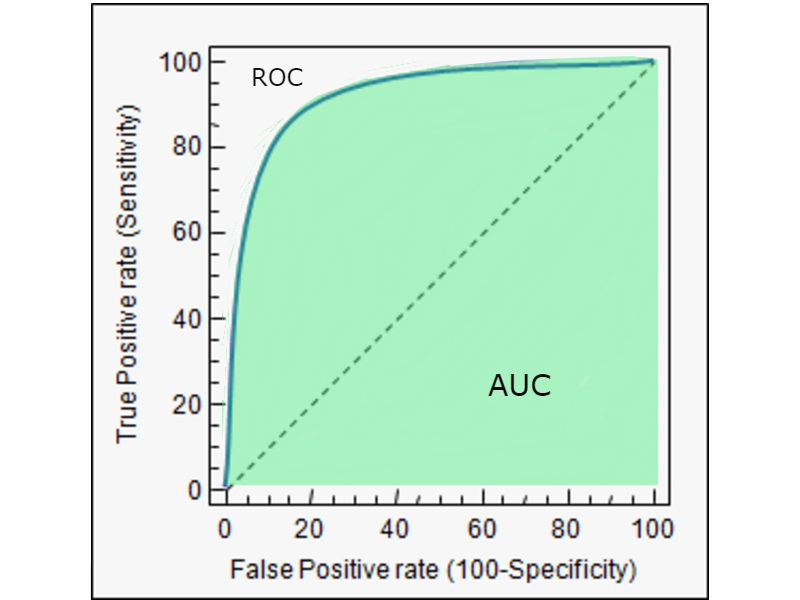

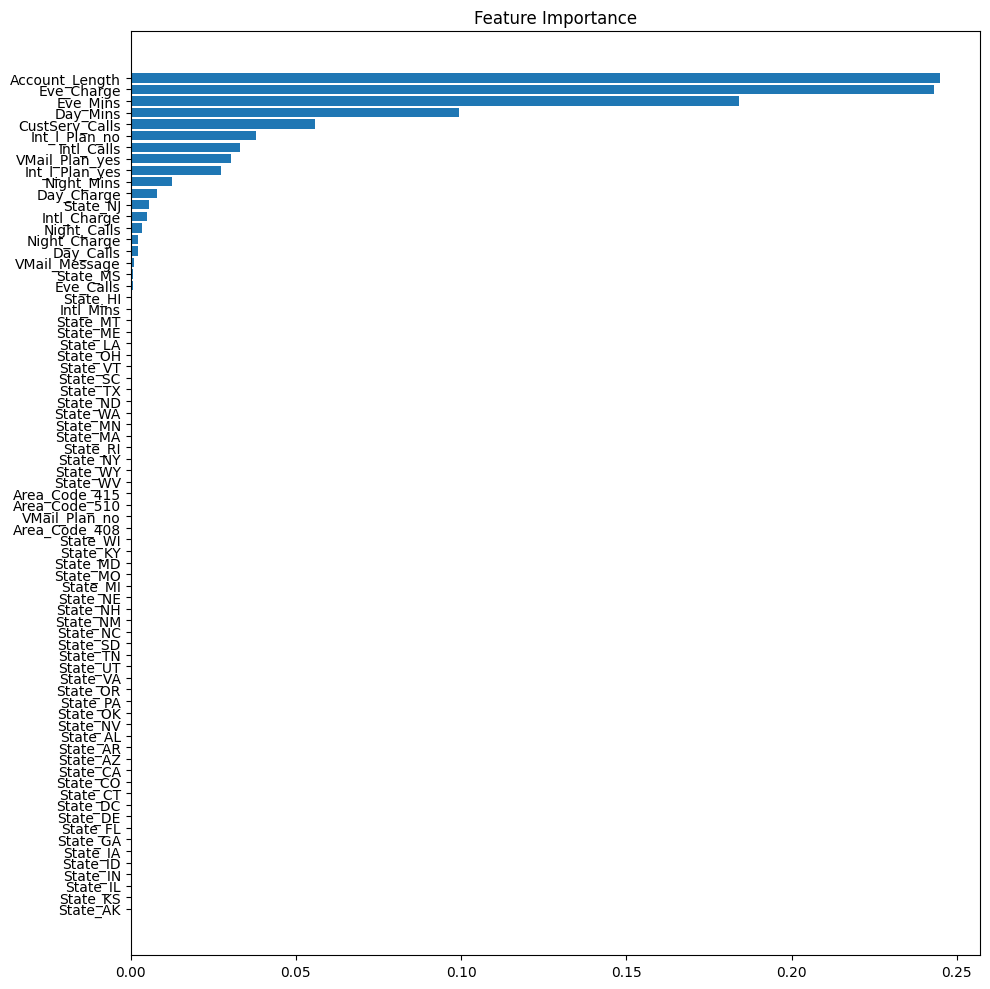

In [33]:
# 의사결정나무 앙상블을 기반으로 하여, GBM 모델을 통해 변수 중요도 추출 가능

# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = clf.feature_importances_

# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)

# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize = (10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_features.columns)[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
plt.show()

In [34]:
# 변수 중요도 (수치 확인)
for i, col in enumerate(dt2.iloc[:, :-1].columns):
    print(f'{col} 중요도 : {clf.feature_importances_[i]}')

print("\n", clf.get_params()) # GradientBoostingClassifier 클래스 인자 설정 정보

State 중요도 : 0.24479520342796535
Account_Length 중요도 : 0.0010324905639089135
Area_Code 중요도 : 0.09935637971352759
Int_l_Plan 중요도 : 0.0022126518549779256
VMail_Plan 중요도 : 0.00811272679954538
VMail_Message 중요도 : 0.1841406947472362
Day_Mins 중요도 : 0.0005921715673687372
Day_Calls 중요도 : 0.24324827203374624
Day_Charge 중요도 : 0.012644316544195735
Eve_Mins 중요도 : 0.0035243806977055757
Eve_Calls 중요도 : 0.002289632606604577
Eve_Charge 중요도 : 0.00033878419841144836
Night_Mins 중요도 : 0.03301888072482227
Night_Calls 중요도 : 0.0049427292078319815
Night_Charge 중요도 : 0.055728835810283824
Intl_Mins 중요도 : 0.0
Intl_Calls 중요도 : 0.0
Intl_Charge 중요도 : 0.0
CustServ_Calls 중요도 : 0.0

 {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'init': None, 'learning_rate': 1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 0, '

> GridSearch를 통한 파라미터 최적화

In [35]:
# 최적 hyper parameter를 찾기 위해 GridSearchCV 실행
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 300, 500],
    'learning_rate' : [ 0.05, 0.1]
}

gb_grid_cv = GridSearchCV(clf , param_grid=params , cv=2 ,verbose=1, n_jobs=-1)
gb_grid_cv.fit(train_X , train_y)
print('최적 하이퍼 파라미터:\n', gb_grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(gb_grid_cv.best_score_))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 100}
최고 예측 정확도: 0.9426


In [36]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 예측 수행
gb_pred = gb_grid_cv.best_estimator_.predict(test_X)
gb_accuracy = accuracy_score(test_y, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

gb_grid_cv_roc_score = roc_auc_score(test_y, gb_grid_cv.predict_proba(test_X)[:,1],average='macro')
print('GBM ROC AUC: {0:.4f}'.format(gb_grid_cv_roc_score))

GBM 정확도: 0.9595
GBM ROC AUC: 0.9149


> 개별 Tree 시각화

In [37]:
# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

# 모델 생성 및 train data로 fitting (학습) 진행
clf = GradientBoostingClassifier(loss             = 'log_loss',
                                 criterion        = 'squared_error', # 개별 트리의 불순도 측도
                                 n_estimators     = 5,
                                 min_samples_leaf = 5,
                                 max_depth        = 3,
                                 learning_rate    = 1,
                                 random_state     = 0)
clf.fit(train_X , train_y)

# GBM 실험 종료에 대한 시간 측정
gb_time = time.time() - start_time
print("GBM 수행 시간: {0:.2f} 초 ".format(gb_time))

GBM 수행 시간: 0.07 초 


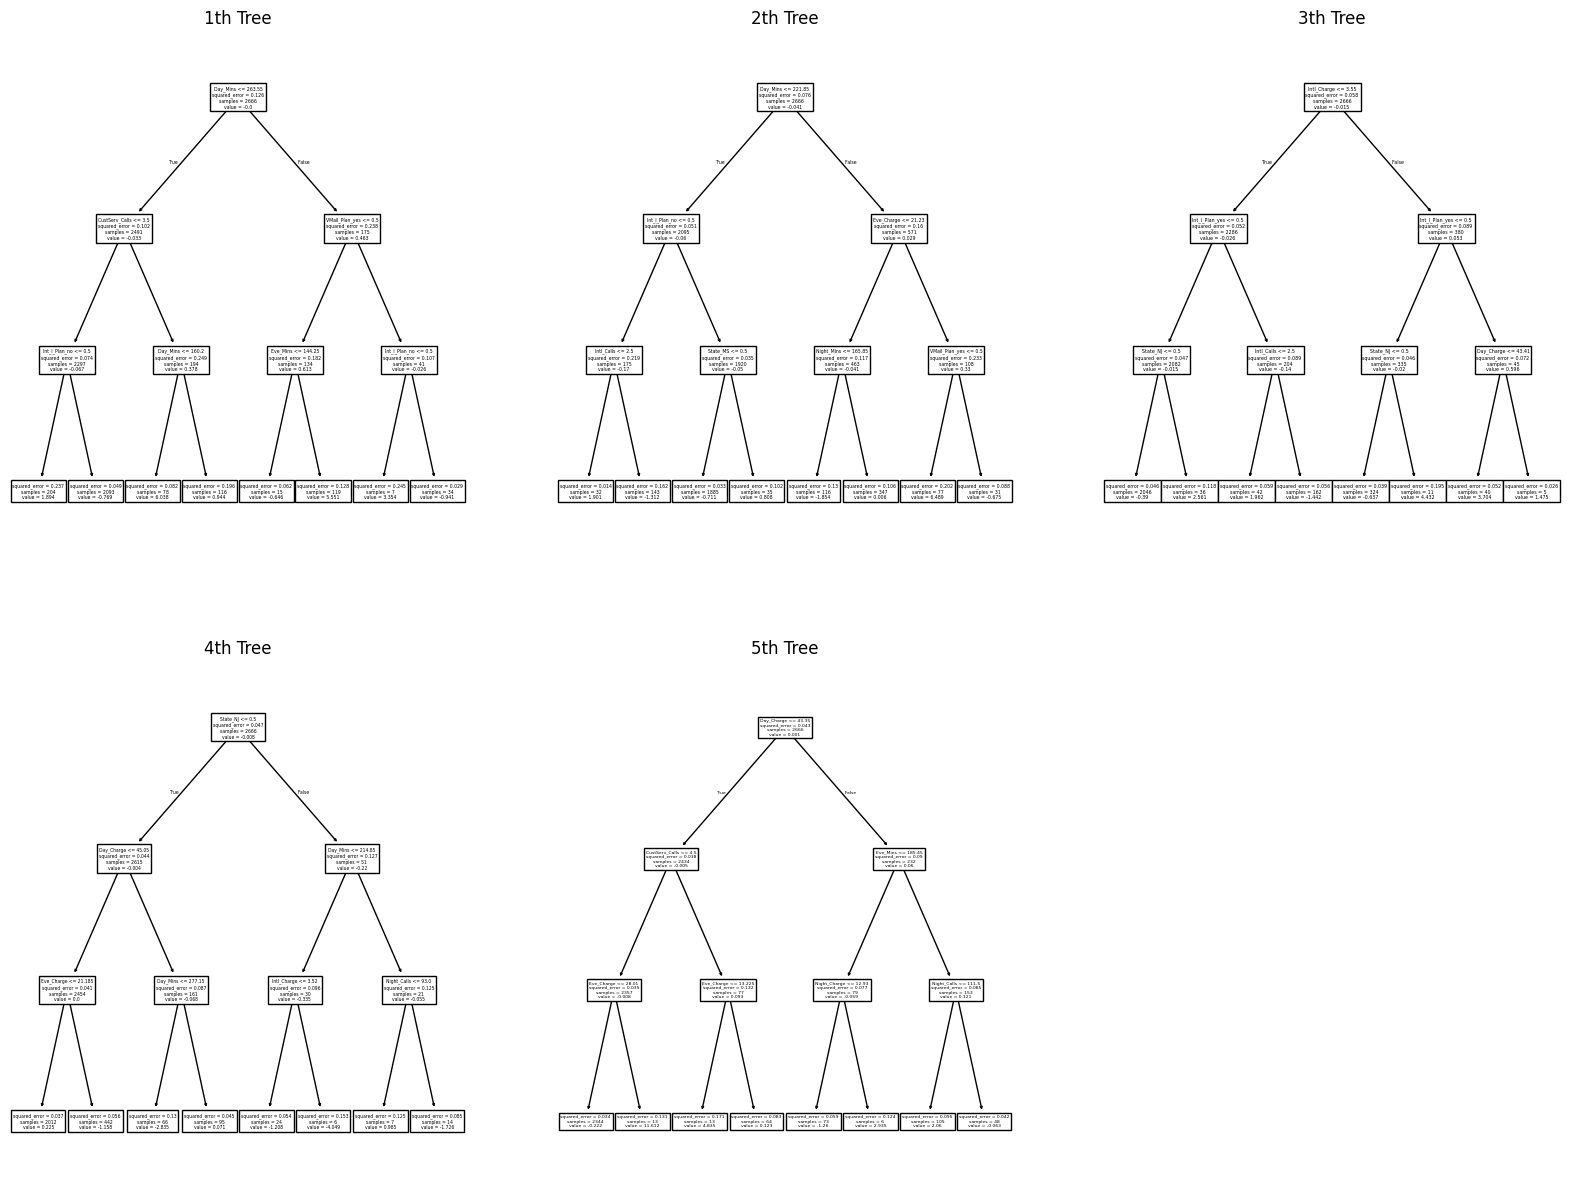

In [38]:
from sklearn.tree import plot_tree

n_estimator = len(clf.estimators_)
fig = plt.figure(figsize=(20, 15), facecolor='white')

row_num=2
col_num=3
for i in range(n_estimator):
    ax = fig.add_subplot(row_num, col_num, i+1)
    plot_tree(clf.estimators_[i][0],
              feature_names=X_features.columns, ## 박스에 변수 이름 표시
              ax=ax
             )
    ax.set_title(f'{i+1}th Tree')
plt.show()